In [11]:
import numpy as np
import pandas as pd

In [12]:
import calendar
import time

def getCurrentTimestamp():
    return int(calendar.timegm(time.gmtime()))

from datetime import datetime

#for ex: 06/12/2021  06:55:00
def convert_date_2_timestamp(time_str):
    #print(time_str)
    try:
        dt = datetime.strptime(time_str, "%d/%m/%Y %H:%M")
        return dt.timestamp()
    except ValueError:
        print("Invalid time format. Please use 'dd/mm/yyyy HH:MM:SS'")
    return None

time_str = "18/2/2024 06:55"
timestamp = convert_date_2_timestamp(time_str)
print(f"Timestamp for {time_str}: {timestamp}") 

Timestamp for 18/2/2024 06:55: 1708239300.0


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, recall_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import seaborn as sns  # For nicer plots (optional)

In [14]:
start_time = getCurrentTimestamp()
path = './data/df_final_red_sum_abs.csv'
print('Begin reading CSV file, please wait ...')
org_df = pd.read_csv(path, low_memory=False)
df = org_df
print('Complete reading CSV file')
total_time = getCurrentTimestamp() - start_time
print('load time:' + str(total_time))
#df -> 2925493 rows × 142 columns
df.describe()

Begin reading CSV file, please wait ...
Complete reading CSV file
load time:0


,Unnamed: 0.1,Unnamed: 0,Submission ID,Transfers : Hour,Transfers : No. of Pax,Transfers : No. of Cargo Lifts/Drops,Lat,Lon,distance,Distance_abs,Total fuel used L,VHM0 (Wave Height),Eastward Wind,Northward Wind,Eastward Current,Northward Current
count,6947.000000,6947.000000,6.947000e+03,6946.000000,6947.000000,6935.000000,6947.000000,6947.000000,6947.000000,6946.000000,6947.000000,4645.000000,6947.000000,6947.000000,6947.000000,6947.000000
mean,10676.924860,10676.924860,8.136921e+07,11.549381,4.673096,2.715357,52.391160,2.388653,12.509459,13.123831,294.601593,0.745393,0.147942,1.056938,-0.022132,-0.158906
std,6998.508139,6998.508139,9.264214e+06,3.880162,2.869124,2.107649,0.314422,0.811950,12.987806,22.022896,301.937394,0.297165,4.120331,4.042826,0.170111,0.589130
min,0.000000,0.000000,6.526061e+07,2.000000,0.000000,0.000000,52.200183,1.736557,0.000000,0.000000,0.000000,0.078000,-11.990000,-11.770000,-0.730000,-1.185000
25%,4098.500000,4098.500000,7.321172e+07,8.000000,3.000000,1.000000,52.245617,1.736557,1.206612,0.000000,28.368669,0.522000,-3.230000,-1.730000,-0.160000,-0.692000
50%,10731.000000,10731.000000,8.095463e+07,11.000000,4.000000,3.000000,52.299750,2.481500,10.127432,2.682713,224.315409,0.776000,0.250000,0.980000,-0.029000,-0.355000
75%,17322.500000,17322.500000,8.990379e+07,15.000000,6.000000,4.000000,52.474199,2.527783,18.768389,30.184125,465.354928,0.946000,3.530000,4.225000,0.074000,0.395000
max,22972.000000,22972.000000,9.864308e+07,22.000000,21.000000,30.000000,54.074279,6.832500,139.729180,193.153174,3133.067118,1.874000,11.340000,11.500000,0.634000,1.204000


In [15]:
#C1 delete unused columns
unused_column_names = ['Unnamed: 0.1', 'Unnamed: 0', 'Submission ID', 'Submission ID generated by device', 'Transfers Date', 'Transfers : Time Question', 'Transfers : No. of Pax', 'Transfers : Hour', 'Transfers : To/From where?', 'Transfers : Transfer Up/Down', 'distance', 'Distance_abs','Transfers : No. of Cargo Lifts/Drops', 'Lat', 'Lon']
df = df.drop(columns=unused_column_names)
df.drop_duplicates()
df.columns

#convert date time to timestamp
df['datetime_sec'] = df['datetime'].apply(convert_date_2_timestamp)
print(df['datetime_sec'][6])

#c3 convert string to numbers
labels, uniques = pd.factorize(df['Vessel'])
df['Vessel_factorized'] = labels
print(df['Vessel_factorized'][0])

#c3 convert string to numbers
labels, uniques = pd.factorize(df['Transfers : Turbine'])
df['turbine_factorized'] = labels
print(df['turbine_factorized'][1:8])

#drop columns that already factorized
df = df.drop(columns = ['datetime', 'Vessel', 'Transfers : Turbine'])
df.columns

print(df['turbine_factorized'].max())

#fill wave NaN by mean
df['VHM0 (Wave Height)'] = df['VHM0 (Wave Height)'].fillna(df['VHM0 (Wave Height)'].mean())

1638788400.0
0
1    1
2    2
3    3
4    3
5    2
6    1
7    0
Name: turbine_factorized, dtype: int64
149


In [16]:
df.columns

Index(['Total fuel used L', 'VHM0 (Wave Height)', 'Eastward Wind',
       'Northward Wind', 'Eastward Current', 'Northward Current',
       'datetime_sec', 'Vessel_factorized', 'turbine_factorized'],
      dtype='object')

In [17]:
print(df['Vessel_factorized'].max())    #5 vessels

5


In [18]:
len(df) #6947

6947

In [19]:
new_rows = []   #used to create data frame
#Create a list of data of based on EACH vessel (Group data for each Vessel because cannot move from the position A to B by 2 different vessels)
for vessel_id in range(0, df['Vessel_factorized'].max()):
    row_index = 1    #skip the first row
    #loop through entire dataset
    while row_index < len(df):
        if df['Vessel_factorized'][row_index] == vessel_id and df['turbine_factorized'][row_index] != df['turbine_factorized'][row_index - 1]:     #ignore first row, the not moving point, and other vessels
            new_row = {
                    'from_turbine': df['turbine_factorized'][row_index - 1], 
                    'to_turbine': df['turbine_factorized'][row_index], 
                    'from_wave_h': df['VHM0 (Wave Height)'][row_index-1],
                    'from_e_wind': df['Eastward Wind'][row_index-1], 
                    'from_n_wind': df['Northward Wind'][row_index-1], 
                    'from_e_current': df['Eastward Current'][row_index-1], 
                    'from_n_current': df['Northward Current'][row_index-1], 
                    'from_time': df['datetime_sec'][row_index],
                    'total_fuel': df['Total fuel used L'][row_index],   #output of model 1
                    'duration': df['datetime_sec'][row_index] - df['datetime_sec'][row_index - 1]  #output of model 2
                }
            new_rows.append(new_row)
        row_index += 1

In [20]:
len(new_rows) #4807

4807

In [21]:
factorized_df = pd.DataFrame(new_rows)

In [22]:
factorized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   from_turbine    4807 non-null   int64  
 1   to_turbine      4807 non-null   int64  
 2   from_wave_h     4807 non-null   float64
 3   from_e_wind     4807 non-null   float64
 4   from_n_wind     4807 non-null   float64
 5   from_e_current  4807 non-null   float64
 6   from_n_current  4807 non-null   float64
 7   from_time       4807 non-null   float64
 8   total_fuel      4807 non-null   float64
 9   duration        4807 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 375.7 KB


In [23]:
Y1_fuel = factorized_df['total_fuel'] #output
X1_fuel = factorized_df.drop(['duration', 'total_fuel'], axis=1) #input

X_train_fuel, X_test_fuel, Y_train_fuel, Y_test_fuel = train_test_split(X1_fuel, Y1_fuel, 
                                                    test_size=0.18, #choose % of data to be tested
                                                    random_state=1)

In [24]:
def run_random_forest(_X_train, _Y_train, _X_test, _Y_test):
    start_time = getCurrentTimestamp()
    #print('Begin training RDF, please wait ...')
    model_rdf = RandomForestRegressor(n_estimators=90, random_state=42)  #default parameters
    #model_rdf = RandomForestRegressor(criterion='poisson', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 15, n_estimators= 90, random_state=42)
    model_rdf.fit(_X_train, _Y_train)
    #print('Finish training RDF ...')

    total_time = getCurrentTimestamp() - start_time
    #print(total_time) #in seconds

    #predict by our model
    y_pred = model_rdf.predict(_X_test)
    #another metric
    arma_rmse = np.sqrt(mean_squared_error(_Y_test, y_pred))
    print("RFC RMSE: ", arma_rmse)

    return arma_rmse

RFC RMSE:  159.34988883430947
RFC RMSE:  185.3827425787051
RFC RMSE:  204.39354121532978
RFC RMSE:  203.96744594653106
RFC RMSE:  200.36558791168875
RFC RMSE:  252.17732974892374
RFC RMSE:  243.4537112718115
RFC RMSE:  235.97928288326167
RFC RMSE:  227.83881690660053
RFC RMSE:  221.84738248484774
RFC RMSE:  219.62367972076234
RFC RMSE:  226.50405666540837
RFC RMSE:  223.59396434910605
RFC RMSE:  227.26021549651904
RFC RMSE:  225.17462642376466
RFC RMSE:  224.20100092069939
RFC RMSE:  236.37203285866474
RFC RMSE:  230.66735082409414
RFC RMSE:  241.31478407862787
[0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.09999999999999999, 0.10999999999999999, 0.11999999999999998, 0.12999999999999998, 0.13999999999999999, 0.15, 0.16, 0.17, 0.18000000000000002, 0.19000000000000003]
[159.34988883430947, 185.3827425787051, 204.39354121532978, 203.96744594653106, 200.36558791168875, 252.17732974892374, 243.4537112718115, 235.97928288326167, 227.83881690660053, 221.8473824848477

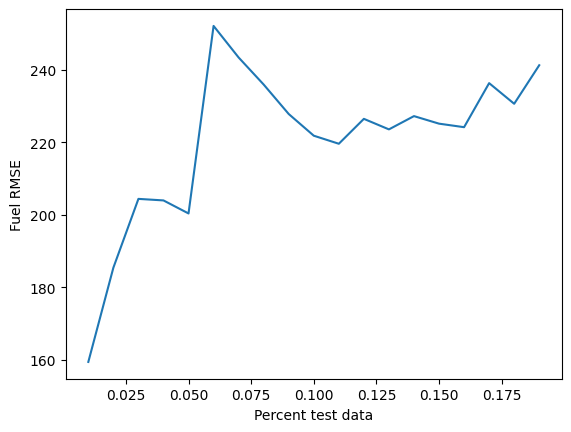

In [25]:
i = 0.01    #initial percentage of testing set
percentX = []
percentY = []
while (i <= 0.2):
    percentX.append(i)
    X_train_fuel, X_test_fuel, Y_train_fuel, Y_test_fuel = train_test_split(X1_fuel, Y1_fuel, 
                                                    test_size=i, #choose % of data to be tested
                                                    random_state=1)
    mse = run_random_forest(X_train_fuel, Y_train_fuel, X_test_fuel, Y_test_fuel)
    percentY.append(mse)
    i += 0.01
print(percentX)
print(percentY)

plt.xlabel('Percent test data')
plt.ylabel('Fuel RMSE')
plt.plot(percentX, percentY)
minY = 100000
minX = 0
for i in range(0,len(percentY)):
    if minY > percentY[i]:
        minY = percentY[i]
        minX = i

print(percentX[minX])   #1%
print(minY)     #159

In [26]:
n_estimators = []   #number of trees
for i in range (10, 100, 10):
    n_estimators.append(i)

In [27]:
def run_random_forest_tuning(_X_train, _Y_train, _X_test, _Y_test):
    start_time = getCurrentTimestamp()
    print('Begin training RDF, please wait ...')

    # 4. Define the parameter grid to search
    param_grid = {
        'n_estimators': n_estimators,  # Number of trees in the forest
        'max_depth': [None, 10, 15, 20,],      # Maximum depth of the trees
        'min_samples_split': [2, 5, 10, 15],   # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4, 6],    # Minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2', None],
        'criterion': ['squared_error', 'absolute_error', 'poisson'],
    }

    # 5. Create the RandomForestRegressor model
    model_rdf = RandomForestRegressor(random_state=42) #Setting a random state ensures consistent results

    # 6. Use GridSearchCV to find the best parameters
    grid_search = GridSearchCV(estimator=model_rdf, param_grid=param_grid, cv=5,  # 5-fold cross-validation
                            scoring='neg_root_mean_squared_error',  # Use negative MSE as the scoring metric
                            n_jobs=-1,  # Use all available cores for parallel processing
                            verbose=2) # Verbose to see the progress

    grid_search.fit(_X_train, _Y_train)
    print('Finish training RDF ...')
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    #60 mins Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 90}
    #RMSE:  162.27
    total_time = getCurrentTimestamp() - start_time
    print('Total time: ' + str(total_time / 1000)) #in seconds

    #predict by our model
    y_pred = grid_search.predict(_X_test)
    #another metric
    arma_rmse = np.sqrt(mean_squared_error(_Y_test, y_pred))
    print("RFC RMSE: ", arma_rmse)

    return arma_rmse

In [28]:
import joblib  # or import pickle


In [29]:
def run_random_forest_and_export(_X_train, _Y_train, _X_test, _Y_test):
    start_time = getCurrentTimestamp()
    #print('Begin training RDF, please wait ...')
    model_rdf = RandomForestRegressor(n_estimators=90, random_state=42)  #default parameters
    #model_rdf = RandomForestRegressor(criterion='poisson', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 15, n_estimators= 90, random_state=42)
    model_rdf.fit(_X_train, _Y_train)
    #print('Finish training RDF ...')

    total_time = getCurrentTimestamp() - start_time
    #print(total_time) #in seconds
    # Save the model
    joblib.dump(model_rdf, 'random_forest_model_1.joblib')  # or pickle.dump(model, open('random_forest_model.pkl', 'wb'))

    #predict by our model
    y_pred = model_rdf.predict(_X_test)
    #another metric
    arma_rmse = np.sqrt(mean_squared_error(_Y_test, y_pred))
    print("RFC RMSE: ", arma_rmse)

    return arma_rmse

In [30]:
X_train_fuel, X_test_fuel, Y_train_fuel, Y_test_fuel = train_test_split(X1_fuel, Y1_fuel, 
                                                    test_size=0.01, #choose % of data to be tested
                                                    random_state=1)
#mse = run_random_forest_and_export(X_train_fuel, Y_train_fuel, X_test_fuel, Y_test_fuel)


In [31]:
#sns.pairplot(data=factorized_df, diag_kind='kde')

In [32]:
factorized_df[0:2]

,from_turbine,to_turbine,from_wave_h,from_e_wind,from_n_wind,from_e_current,from_n_current,from_time,total_fuel,duration
0,0,1,0.745393,1.69,3.57,-0.097,-0.629,1.638779e+09,673.887565,5100.0
1,1,2,1.304000,0.95,8.94,-0.065,-0.305,1.638781e+09,198.464028,1920.0


In [33]:
X_train_fuel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4758 entries, 4156 to 235
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   from_turbine    4758 non-null   int64  
 1   to_turbine      4758 non-null   int64  
 2   from_wave_h     4758 non-null   float64
 3   from_e_wind     4758 non-null   float64
 4   from_n_wind     4758 non-null   float64
 5   from_e_current  4758 non-null   float64
 6   from_n_current  4758 non-null   float64
 7   from_time       4758 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 334.5 KB


In [34]:
# Load the model later
loaded_model = joblib.load('random_forest_model_1.joblib')  # or pickle.load(open('random_forest_model.pkl', 'rb'))

# Use the loaded model for predictions
predictions = loaded_model.predict(pd.DataFrame({
                    'from_turbine': [1], 
                    'to_turbine': [2], 
                    'from_wave_h': [1.304],
                    'from_e_wind': [0.95]	, 
                    'from_n_wind': [8.94], 
                    'from_e_current': [-0.065], 
                    'from_n_current': [-0.305], 
                    'from_time': [1638781000]
                }))
print(predictions)

[228.49270392]


In [38]:
points = [0, 2, 3, 5, 7]
from_time = 1638781000

#break down into pairs of turbines
import itertools
pairs = list(itertools.combinations(points, 2))  # 2 specifies pairs
print(pairs)
pair_len = len(pairs)
distances = {}   #key: pair, value: predicted fuel
for i in range(0, pair_len):
    predicted_value = loaded_model.predict(pd.DataFrame({
                    'from_turbine': [pairs[i][0]], 
                    'to_turbine': [pairs[i][1]], 
                    'from_wave_h': [1.304],
                    'from_e_wind': [0.95]	, 
                    'from_n_wind': [8.94], 
                    'from_e_current': [-0.065], 
                    'from_n_current': [-0.305], 
                    'from_time': [1638781000]
                }))
    distances[pairs[i]] = predicted_value[0]

[(0, 2), (0, 3), (0, 5), (0, 7), (2, 3), (2, 5), (2, 7), (3, 5), (3, 7), (5, 7)]


In [39]:
distances

{(0, 2): 853.2833940330391,
 (0, 3): 849.1900255468504,
 (0, 5): 847.1056140089172,
 (0, 7): 849.5357101309284,
 (2, 3): 267.5227924683428,
 (2, 5): 281.4817788456153,
 (2, 7): 286.7248997253633,
 (3, 5): 282.031871795202,
 (3, 7): 287.27499267494994,
 (5, 7): 309.1277734903459}

In [ ]:
def shortest_path_starting_from_first(points, distances):
    """
    Finds the shortest path that visits all points exactly once, 
    starting from the first point in the list.

    Args:
        points: A list of point labels (e.g., ['A', 'B', 'C', 'D', 'E']).
        distances: A dictionary where keys are tuples of two points (in any order)
                   and values are the distances between them.

    Returns:
        A tuple containing:
            - The shortest path (a list of point labels in order).
            - The total distance of the shortest path.
    """

    if not points:
        return [], 0  # Handle empty points list

    start_point = points[0]
    remaining_points = points[1:]

    min_distance = float('inf')
    shortest_path_found = None

    for path_permutation in itertools.permutations(remaining_points):
        current_path = [start_point] + list(path_permutation) # Prepend the starting point
        total_distance = 0
        for i in range(len(current_path) - 1):
            current_point = current_path[i]
            next_point = current_path[i + 1]
            distance = distances.get((current_point, next_point)) or distances.get((next_point, current_point))
            if distance is None:
                raise ValueError(f"Distance between {current_point} and {next_point} not defined.")
            total_distance += distance

        if total_distance < min_distance:
            min_distance = total_distance
            shortest_path_found = current_path

    return shortest_path_found, min_distance


# Example usage:
#points = ['A', 'B', 'C', 'D', 'E']

#distances = {
#    ('A', 'B'): 10, ('B', 'A'): 10,
#    ('A', 'C'): 15, ('C', 'A'): 15,
#    ('A', 'D'): 20, ('D', 'A'): 20,
#    ('A', 'E'): 25, ('E', 'A'): 25,
#    ('B', 'C'): 35, ('C', 'B'): 35,
#    ('B', 'D'): 25, ('D', 'B'): 25,
#    ('B', 'E'): 30, ('E', 'B'): 30,
#    ('C', 'D'): 15, ('D', 'C'): 15,
#    ('C', 'E'): 20, ('E', 'C'): 20,
#    ('D', 'E'): 10, ('E', 'D'): 10,
#}

shortest_path_result, min_distance_result = shortest_path_starting_from_first(points, distances)
print("Shortest Path:", shortest_path_result)
print("Total Fuel:", min_distance_result)



Shortest Path: [0, 5, 2, 3, 7]
Total Distance: 1683.3851779978252
